In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud, STOPWORDS
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193659 sha256=4a490fa9b91c0aaccd86ef6191cf93a2083869052399faabab5c51faca5e6cb5
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
md = pd. read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Exploring dataset

In [21]:
md.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year'],
      dtype='object')

In [22]:
md.shape

(45463, 25)

In [23]:
md.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45463 entries, 0 to 45465
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  object 
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  object 
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45460 non-null  object 
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45376 non-null  object 
 15  re

In [24]:
md['title'] = md['title'].astype('str')
md['overview'] = md['overview'].astype('str')

In [25]:
title_corpus = ' '.join(md['title'])
overview_corpus = ' '.join(md['overview'])

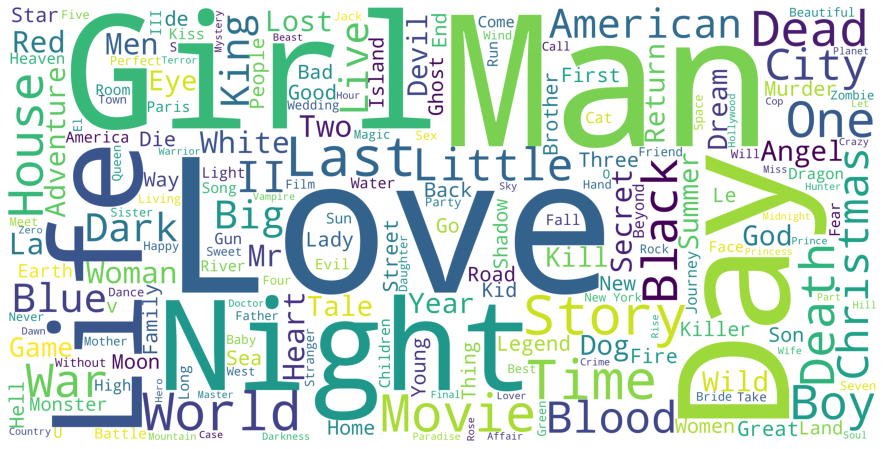

In [27]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

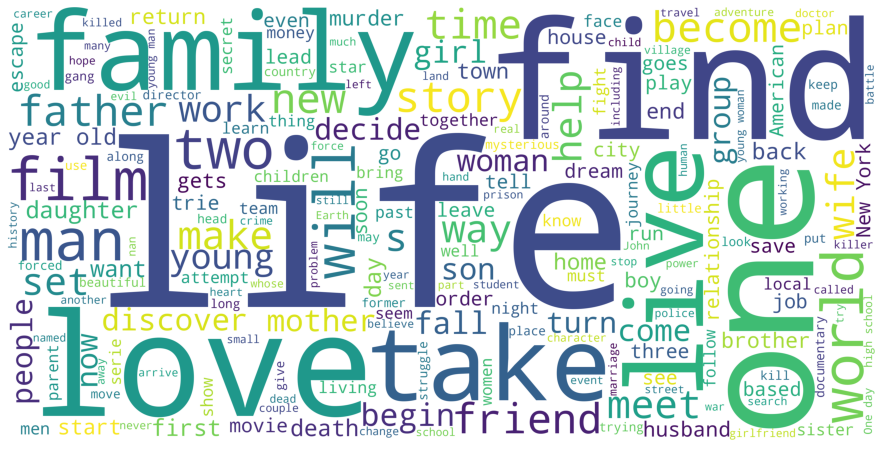

In [28]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

Demographic Filtering 
* Recommendation using ratings, voting, genre, popularity. 
* Doesn't recommend according to personal taste, rather generalised


In [6]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [7]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [8]:
m = vote_counts.quantile(0.95)
m

434.0

In [9]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [10]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

To qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. 2274 Movies qualify to be on our chart.

In [11]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

Using weighted rating forumul according to TMDB

In [12]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [13]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

Printing popular movies

In [14]:
qualified.head(12)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


Filtering based on genre

In [15]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [16]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [17]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


**Content based recommendation**

In [18]:
links_small = pd.read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [19]:
md = md.drop([19730, 29503, 35587])

In [20]:
md['id'] = md['id'].astype('int')

In [29]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

Description based recommendation

In [30]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [31]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [32]:
tfidf_matrix.shape

(9099, 268124)

In [33]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [34]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [35]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [36]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [38]:
get_recommendations('Iron Man').head(10)

8285                 Iron Man 3
7506                 Iron Man 2
8758    Avengers: Age of Ultron
8090                      Brake
6055                    Hostage
5661                   Scarface
279           The Swan Princess
7082                       Igor
3009          Missing in Action
5177            The Magic Flute
Name: title, dtype: object

In [40]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

Metadata based recommendation

In [41]:
credits = pd.read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/keywords.csv')

In [42]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [43]:
md.shape

(45463, 25)

In [44]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [45]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

In [46]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [47]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [48]:
smd['director'] = smd['crew'].apply(get_director)

In [49]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [50]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [51]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [52]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [53]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [54]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [55]:
s = s[s > 1]

In [57]:
stemmer = SnowballStemmer('english')
stemmer.stem('cats')

'cat'

In [58]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [59]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [60]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [61]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [62]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [63]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [64]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [65]:
get_recommendations('Iron Man').head(10)

7600                    Iron Man 2
3536                          Made
8392                    Iron Man 3
6359    Zathura: A Space Adventure
7793              Cowboys & Aliens
8661                          Chef
4930                           Elf
7969                  The Avengers
9028               The Jungle Book
8869                       Ant-Man
Name: title, dtype: object

In [66]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [67]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


In [68]:
improved_recommendations('Iron Man')

,title,vote_count,vote_average,year,wr
7969,The Avengers,12000,7,2012,6.938739
8712,Guardians of the Galaxy,10014,7,2014,6.927095
8872,Captain America: Civil War,7462,7,2016,6.903532
8868,Avengers: Age of Ultron,6908,7,2015,6.896252
8869,Ant-Man,6029,7,2015,6.882142
8626,Captain America: The Winter Soldier,5881,7,2014,6.879380
7889,X-Men: First Class,5252,7,2011,6.866037
8392,Iron Man 3,8951,6,2013,5.965081
7923,Captain America: The First Avenger,7174,6,2011,5.956925
7600,Iron Man 2,6969,6,2010,5.955732


Collaborative Filtering
* Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.
* Using surprise library (Singular value decomposition algorithm)

In [71]:
reader = Reader()

In [73]:
ratings = pd.read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [76]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [75]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.89743312, 0.89405235, 0.89258637, 0.89906298, 0.89500135]),
 'test_mae': array([0.69205598, 0.68876023, 0.6863267 , 0.69325652, 0.690258  ]),
 'fit_time': (2.953145980834961,
  1.4270577430725098,
  1.484095811843872,
  1.4474878311157227,
  1.488330602645874),
 'test_time': (0.3477184772491455,
  0.15442776679992676,
  0.14037275314331055,
  0.3333125114440918,
  0.15651321411132812)}

In [80]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [81]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [82]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.849742819300081, details={'was_impossible': False})

Hybrid recommendation


In [83]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [85]:
id_map = pd.read_csv('/content/drive/MyDrive/GeneralNoteBooks/CodeClause/movie_data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')


In [86]:
indices_map = id_map.set_index('id')

In [87]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [88]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.102077
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.088701
1011,The Terminator,4208.0,7.4,1984,218,3.072717
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.027038
922,The Abyss,822.0,7.1,1989,2756,3.026508
1621,Darby O'Gill and the Little People,35.0,6.7,1959,18887,2.971428
974,Aliens,3282.0,7.7,1986,679,2.929021
2014,Fantastic Planet,140.0,7.6,1973,16306,2.859308
7088,Star Wars: The Clone Wars,434.0,5.8,2008,12180,2.742539
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.727717


In [89]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.672622
1376,Titanic,7770.0,7.5,1997,597,3.355703
3060,Sinbad and the Eye of the Tiger,39.0,6.3,1977,11940,3.219887
2014,Fantastic Planet,140.0,7.6,1973,16306,3.182350
7265,Dragonball Evolution,475.0,2.9,2009,14164,3.174850
974,Aliens,3282.0,7.7,1986,679,3.158537
1668,Return from Witch Mountain,38.0,5.6,1978,14822,3.037797
344,True Lies,1138.0,6.8,1994,36955,3.023473
4017,Hawk the Slayer,13.0,4.5,1980,25628,3.003279
922,The Abyss,822.0,7.1,1989,2756,2.988266
